# Import Data and Library

In [196]:
import pandas as pd
import scipy
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from scipy import stats
from sklearn.model_selection import train_test_split
from imblearn import under_sampling, over_sampling
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

In [197]:
df = pd.read_csv('loan_data_2007_2014.csv')
df.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [198]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

# Data Preparation

In [199]:
#Drop nulls columns
null_col = []
for i in df.columns:
    if df[i].isna().sum() == df.shape[0]:
        null_col.append(i)
df.drop(columns=null_col,axis=1,inplace=True) 

#drop id columns
df.drop(columns=['Unnamed: 0'],axis=1,inplace=True)

In [200]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 57 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           466285 non-null  int64  
 1   member_id                    466285 non-null  int64  
 2   loan_amnt                    466285 non-null  int64  
 3   funded_amnt                  466285 non-null  int64  
 4   funded_amnt_inv              466285 non-null  float64
 5   term                         466285 non-null  object 
 6   int_rate                     466285 non-null  float64
 7   installment                  466285 non-null  float64
 8   grade                        466285 non-null  object 
 9   sub_grade                    466285 non-null  object 
 10  emp_title                    438697 non-null  object 
 11  emp_length                   445277 non-null  object 
 12  home_ownership               466285 non-null  object 
 13 

In [201]:
print('id # unique :',df['id'].nunique())
print('member_id # unique :',df['member_id'].nunique())

id # unique : 466285
member_id # unique : 466285


Data were borrowers loan data not transaction data. We can drop id and member_id

In [202]:
df.drop(columns=['id','member_id'],axis=1,inplace=True)

**Data Dictionary**
- loan_amnt : Last month payment was received
- funded_amnt : The total amount committed to that loan at that point in time.
- funded_amnt_inv : 
- term : The number of payments on the loan. Values are in months and can be either 36 or 60.
- int_rate : Indicates if income was verified by LC, not verified, or if the income source was verified
- installment : The monthly payment owed by the borrower if the loan originates.
- grade : LC assigned loan grade.
- sub_grade : LC assigned loan subgrade.
- emp_title : The job title supplied by the Borrower when applying for the loan.*
- emp_length : Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 
- home_ownership : The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER.
- annual_inc : The self-reported annual income provided by the borrower during registration.
- verification_status : 
- issue_d : The month which the loan was funded
- loan_status : Current status of the loan
- pymnt_plan : 
- url : URL for the LC page with listing data.
- desc : Loan description provided by the borrower
- purpose : A category provided by the borrower for the loan request. 
- title : The loan title provided by the borrower
- zip_code : -
- addr_state : -
- dti : A ratio calculated using the co-borrowers' total monthly payments on the total debt obligations, excluding mortgages and the requested LC loan, divided by the co-borrowers' combined self-reported monthly income

- delinq_2yrs : The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
- earliest_cr_line : The month the borrower's earliest reported credit line was opened
- inq_last_6mths : The number of inquiries in past 6 months (excluding auto and mortgage inquiries)
- mths_since_last_delinq : The number of months since the borrower's last delinquency.
- mths_since_last_record : The number of months since the last public record.
- open_acc : The number of open credit lines in the borrower's credit file.
- pub_rec : Number of derogatory public records

- revol_bal : Total credit revolving balance
- revol_util : Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.        

- total_acc : The total number of credit lines currently in the borrower's credit file
- initial_list_status : The initial listing status of the loan. Possible values are – Whole, Fractional
- out_prncp : Remaining outstanding principal for total amount funded
- out_prncp_inv : Remaining outstanding principal for portion of total amount funded by investors
- total_pymnt : Payments received to date for total amount funded
- total_pymnt_inv : Payments received to date for portion of total amount funded by investors
- total_rec_prncp : Principal received to date
- total_rec_int : Interest received to date
- total_rec_late_fee : Late fees received to date
- recoveries : Indicates if a payment plan has been put in place for the loan
- collection_recovery_fee : post charge off collection fee
- last_pymnt_d : Last month payment was received
- last_pymnt_amnt : Last total payment amount received
- next_pymnt_d : Next scheduled payment date
- last_credit_pull_d : - 
- collections_12_mths_ex_med : Number of collections in 12 months excluding medical collections
- mths_since_last_major_derog : Months since most recent 90-day or worse rating
- policy_code : publicly available policy_code=1,new products not publicly available policy_code=2
- application_type : Indicates whether the loan is an individual application or a joint application with two co-borrowers
- acc_now_delinq : The number of accounts on which the borrower is now delinquent.
- tot_coll_amt : Total collection amounts ever owed
- tot_cur_bal : Total current balance of all accounts
- total_rev_hi_lim : - 

From data dictionary we can analyze which feature does not relevant in model.
- url, desc, title, zip_code, addr_state, emp_title may not have good information about credit score and will be dropped.
- funded_amnt_inv, out_prncp_inv, total_pymnt_inv will be dropped.
- sub_grade i think no necessary because we have grade feature that will be enough to segment category grade.
- title i think have good information, but it is have high cardinality and will be dropped.

In [203]:
drop_col = ['url', 'desc', 'title', 'zip_code', 'addr_state', 'emp_title','funded_amnt_inv', 'out_prncp_inv', 
            'total_pymnt_inv','sub_grade','title']
df.drop(columns=drop_col,axis=1,inplace=True)

In [204]:
df.head(3).T

,0,1,2
loan_amnt,5000,2500,2400
funded_amnt,5000,2500,2400
term,36 months,60 months,36 months
int_rate,10.65,15.27,15.96
installment,162.87,59.83,84.33
grade,B,C,C
emp_length,10+ years,< 1 year,10+ years
home_ownership,RENT,RENT,RENT
annual_inc,24000.0,30000.0,12252.0
verification_status,Verified,Source Verified,Not Verified


# EDA

## Univariate Analysis

In [205]:
cat = [i for i in df.columns if df[i].dtype == 'O']
num = [i for i in df.columns if df[i].dtype != 'O']

In [206]:
df_eda = df.copy()

In [207]:
df_eda[cat].nunique()

term                     2
grade                    7
emp_length              11
home_ownership           6
verification_status      3
issue_d                 91
loan_status              9
pymnt_plan               2
purpose                 14
earliest_cr_line       664
initial_list_status      2
last_pymnt_d            98
next_pymnt_d           100
last_credit_pull_d     103
application_type         1
dtype: int64

In [208]:
#check feature with high cardinality and constant
high_cardinal_or_constant = [i for i in cat if (df[i].nunique() > 50) or (df[i].nunique() == 1)]
df_eda[high_cardinal_or_constant].head()

,issue_d,earliest_cr_line,last_pymnt_d,next_pymnt_d,last_credit_pull_d,application_type
0,Dec-11,Jan-85,Jan-15,NaN,Jan-16,INDIVIDUAL
1,Dec-11,Apr-99,Apr-13,NaN,Sep-13,INDIVIDUAL
2,Dec-11,Nov-01,Jun-14,NaN,Jan-16,INDIVIDUAL
3,Dec-11,Feb-96,Jan-15,NaN,Jan-15,INDIVIDUAL
4,Dec-11,Jan-96,Jan-16,Feb-16,Jan-16,INDIVIDUAL


High cardinality mostly have date values and i think have no effect on loan and will be dropped.

In [209]:
cat = [i for i in df.columns if df[i].dtype == 'O']
df[cat].nunique()

term                     2
grade                    7
emp_length              11
home_ownership           6
verification_status      3
issue_d                 91
loan_status              9
pymnt_plan               2
purpose                 14
earliest_cr_line       664
initial_list_status      2
last_pymnt_d            98
next_pymnt_d           100
last_credit_pull_d     103
application_type         1
dtype: int64

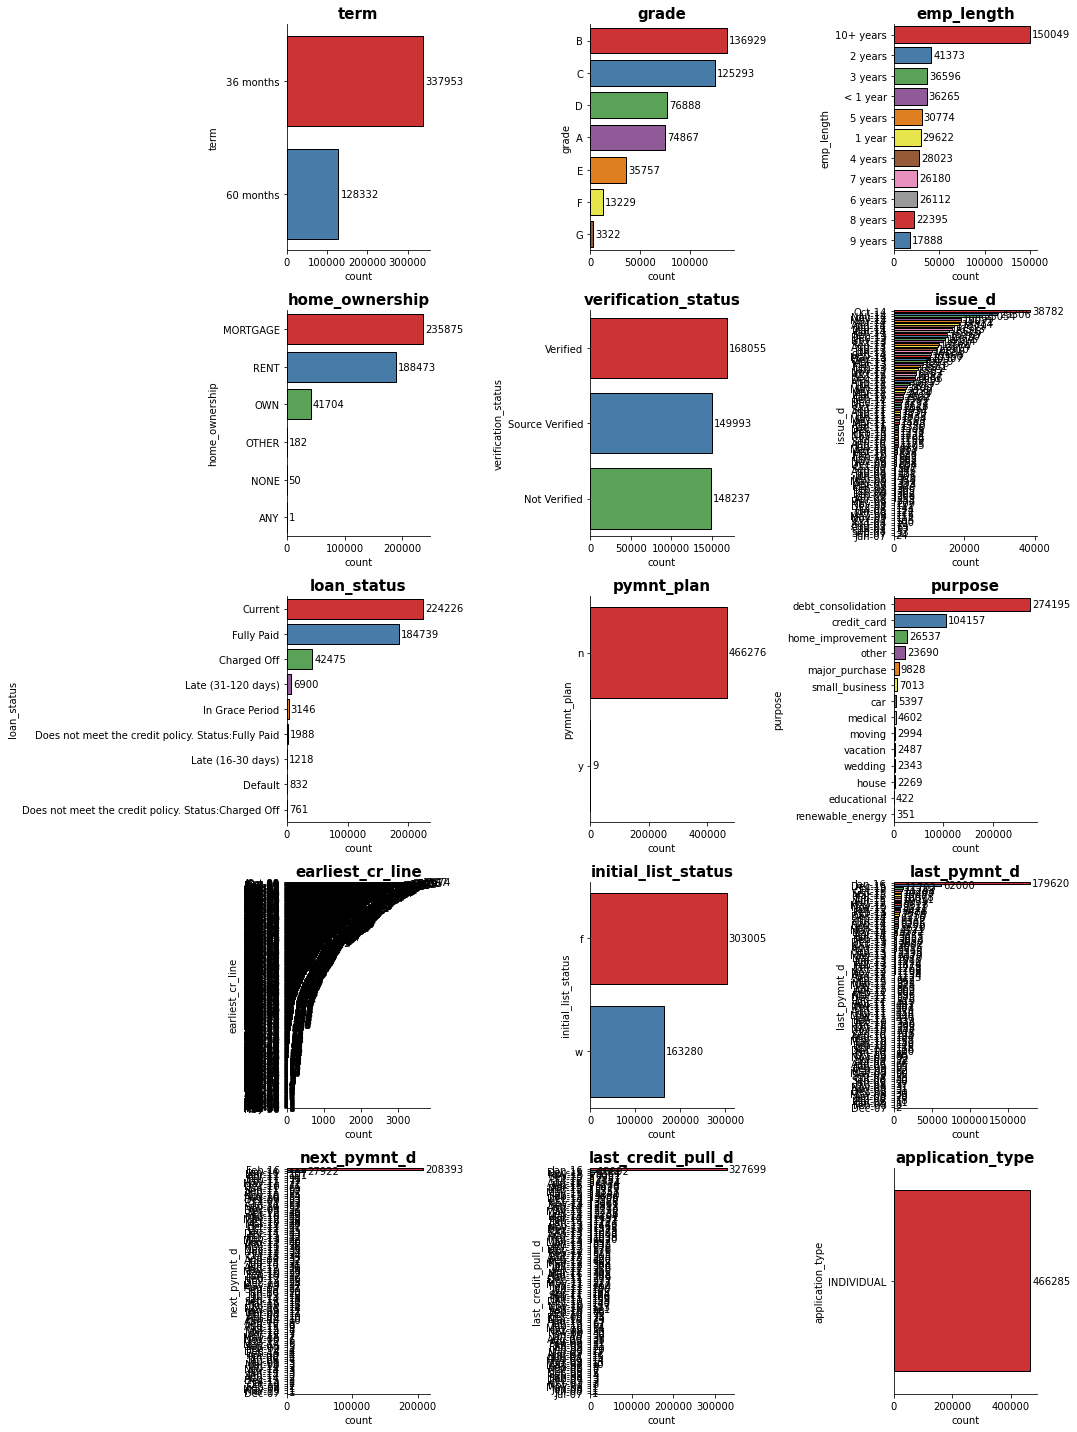

In [210]:
plt.figure(figsize=(15,20))
for i in range(len(cat)):
    plt.subplot(5,3, i+1)
    ax = sns.countplot(y=cat[i], data=df, palette='Set1', order=df[cat[i]].value_counts().index,edgecolor='black')
    plt.bar_label(ax.containers[0], padding=2)
    ax.set_title(cat[i], fontsize=15, color='black', weight='bold')
sns.despine()
plt.tight_layout()

plt.savefig('loan_status_prediction/images/uni_cat.jpg', dpi=400)

plt.show()

"pymnt_plan" distribution does not have any good information we wil drop this column. loan_status is the target feature and will be simplified to be positive and negative borrowers.

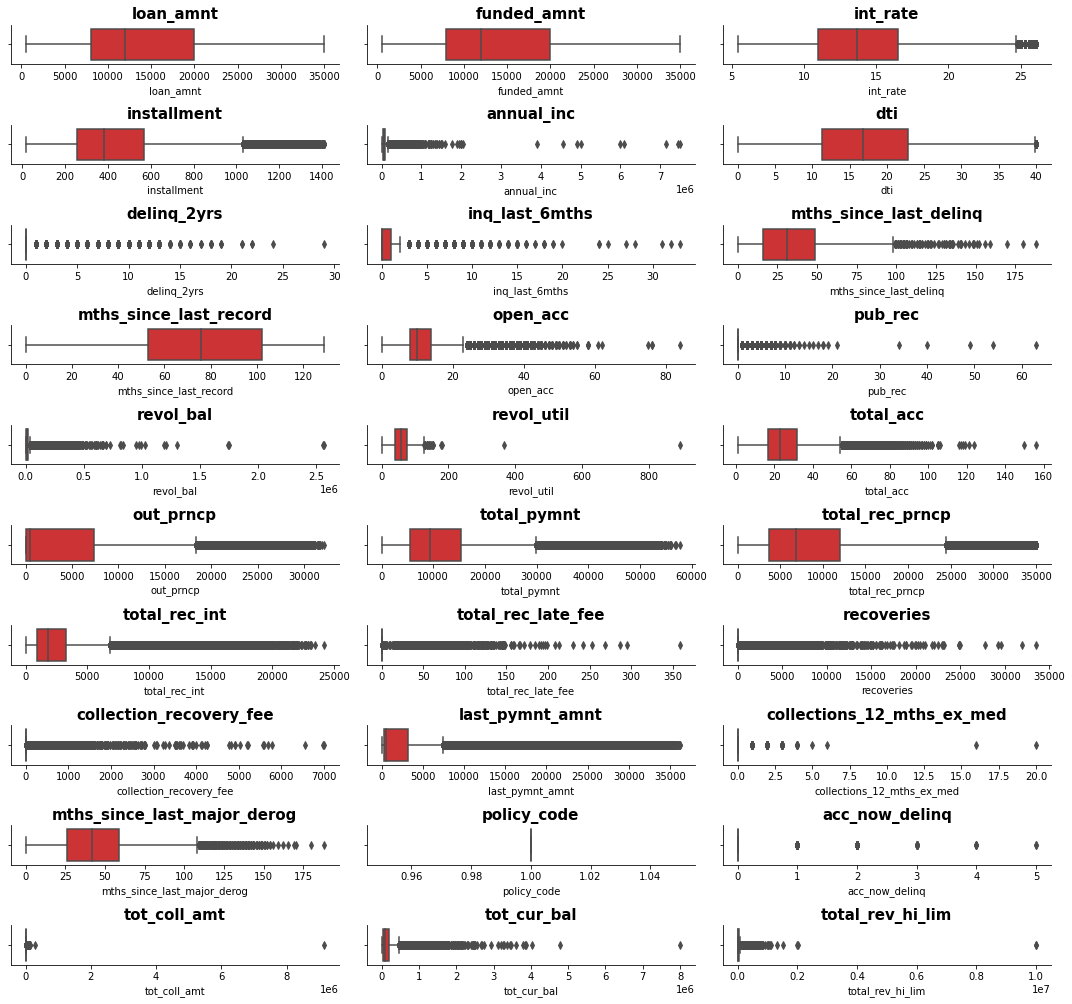

In [211]:
plt.figure(figsize=(15,15))
for i in range(len(num)):
    plt.subplot(11,3, i+1)
    ax = sns.boxplot(x=num[i], data=df, palette='Set1')
    ax.set_title(num[i], fontsize=15, color='black', weight='bold')

sns.despine()
plt.tight_layout()
plt.savefig('loan_status_prediction/images/uni_num.jpg', dpi=400)

plt.show()

## Multivariate Analysis

In [212]:
df['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [213]:
#Our target is loan_status lets try encode loan status
#1 : Fully Paid, Current ,Grace Period positive borrowers 
#0 : Charged Off, Default, Late, , Does not meet policy, negative borrowers

df['status'] = df['loan_status'].map(lambda x: 1 if x in ['Fully Paid','Current','In Grace Period'] else 0)
df.drop('loan_status',axis=1,inplace=True)

In [214]:
cat = [i for i in df.columns if df[i].dtype == 'O']
num = [i for i in df.columns if df[i].dtype != 'O']

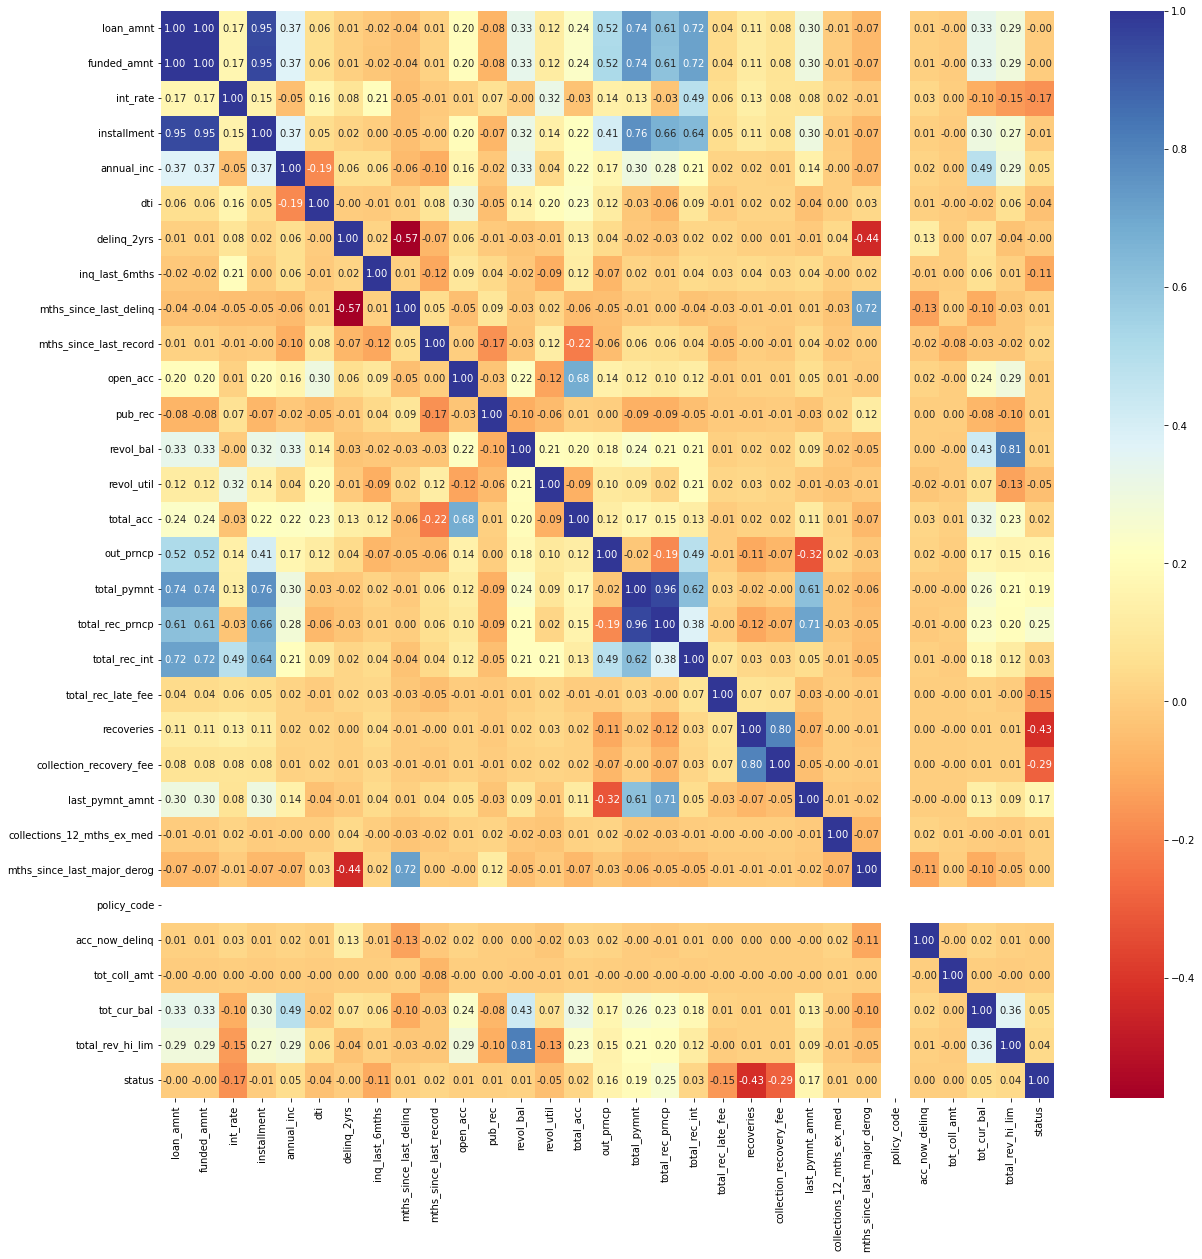

In [215]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(), cmap='RdYlBu', annot=True, fmt='.2f')
plt.show()
# plt.savefig('corr.png')

Loan amount and funded amount have 1 corelation we need to consider to pick one for model feature

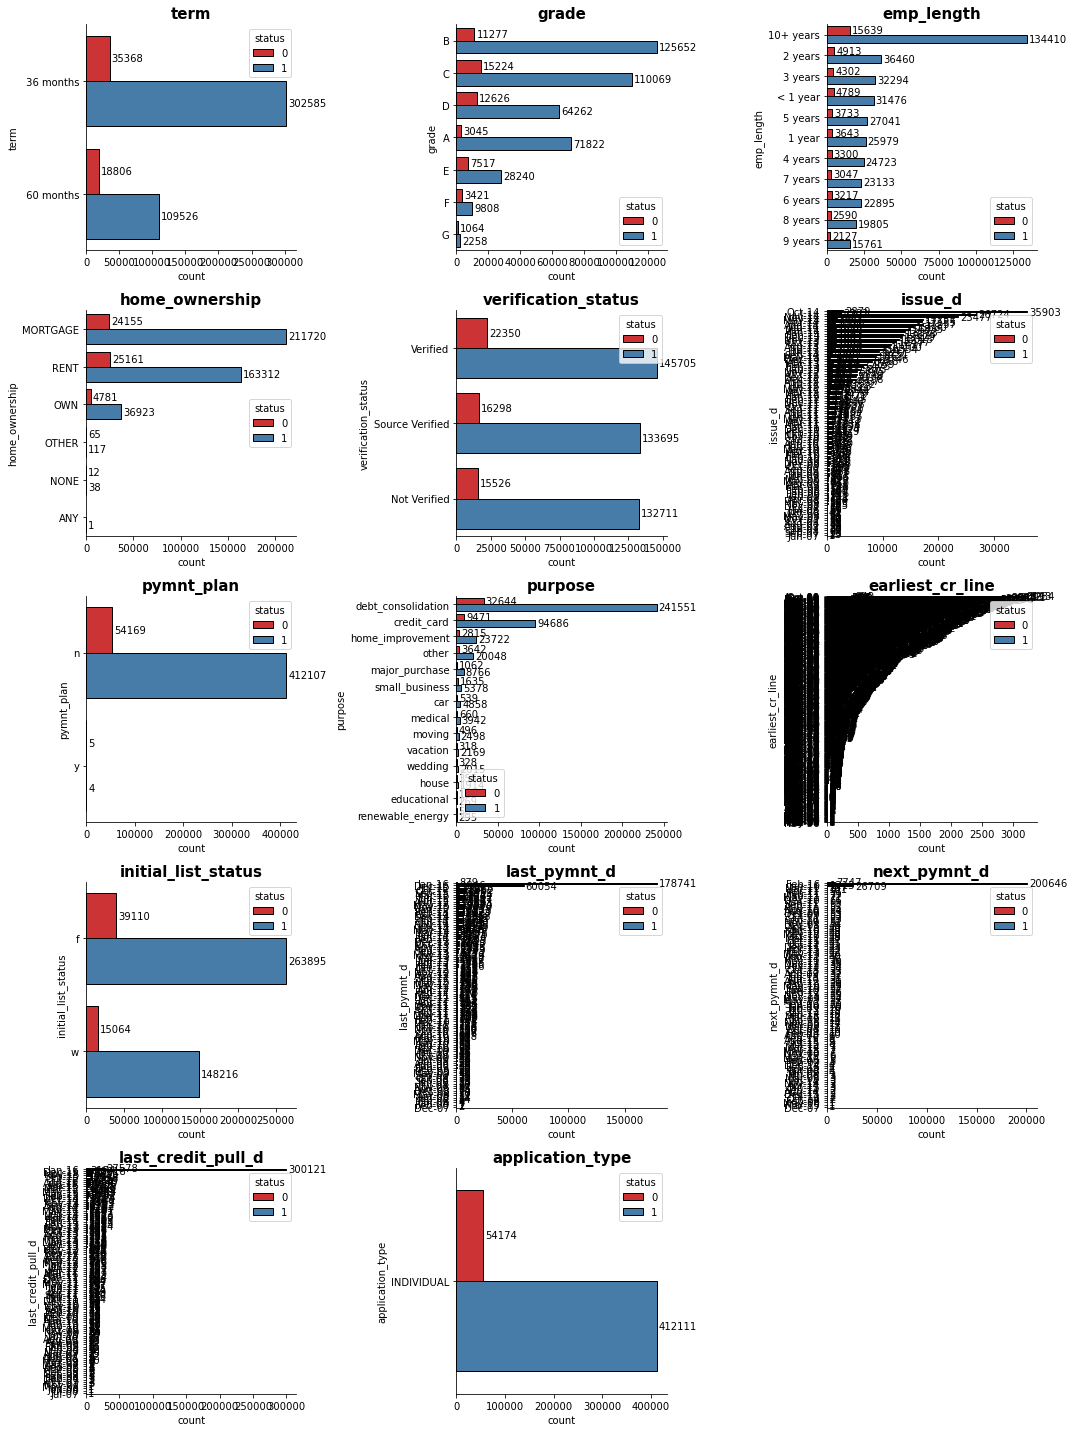

In [216]:
plt.figure(figsize=(15,20))
for i in range(len(cat)):
    plt.subplot(5,3, i+1)
    ax = sns.countplot(y=cat[i], data=df, palette='Set1', order=df[cat[i]].value_counts().index,edgecolor='black',hue='status')
    plt.bar_label(ax.containers[0], padding=2)
    plt.bar_label(ax.containers[1], padding=2)
    ax.set_title(cat[i], fontsize=15, color='black', weight='bold')
sns.despine()
plt.tight_layout()
plt.savefig('loan_status_prediction/images/multi_cat.jpg', dpi=400)

plt.show()

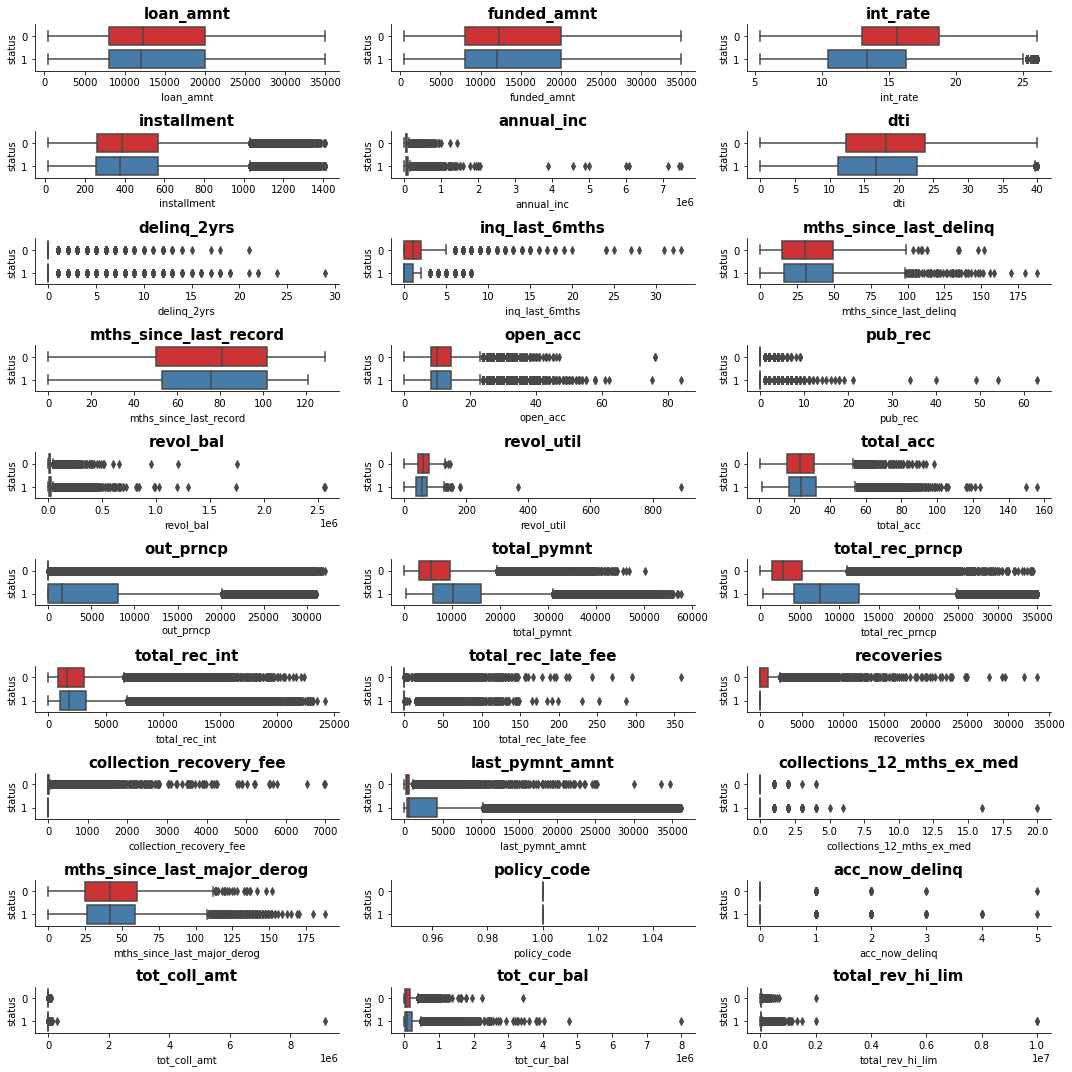

In [217]:
df['status'] = df['status'].astype('category')
plt.figure(figsize=(15,15))
for i in range(len(num)-1):
    plt.subplot(10,3, i+1)
    ax = sns.boxplot(x=num[i], data=df, palette='Set1',y='status')
    ax.set_title(num[i], fontsize=15, color='black', weight='bold')

sns.despine()
plt.tight_layout()
plt.savefig('loan_status_prediction/images/multi_num.jpg', dpi=400)
plt.show()

# Data Preprocessing

## Drop columns

In [96]:
#drop high cardinality and constant columns columns
df.drop(columns=high_cardinal_or_constant,axis=1,inplace=True)

#drop payment_plan
df.drop(columns='pymnt_plan',axis=1,inplace=True)

#drop columns that may be contain leak information and constant
df.drop(columns=['recoveries','collection_recovery_fee','policy_code','loan_amnt'],axis=1,inplace=True)

## Imputate Missing Values

In [97]:
#percent missing values
for i in df.columns:
    per = round((df[i].isna().sum()/df.shape[0])*100,2)
    if per > 1:
        print(f"{i} : {per}")

emp_length : 4.51
mths_since_last_delinq : 53.69
mths_since_last_record : 86.57
mths_since_last_major_derog : 78.77
tot_coll_amt : 15.07
tot_cur_bal : 15.07
total_rev_hi_lim : 15.07


In [98]:
#drop feature with missing values > 20%
drop_col = ['mths_since_last_delinq','mths_since_last_record','mths_since_last_major_derog']
df.drop(columns=drop_col,axis=1,inplace=True)

In [99]:
df.isna().sum()[df.isna().sum()>0]

emp_length                    21008
annual_inc                        4
delinq_2yrs                      29
inq_last_6mths                   29
open_acc                         29
pub_rec                          29
revol_util                      340
total_acc                        29
collections_12_mths_ex_med      145
acc_now_delinq                   29
tot_coll_amt                  70276
tot_cur_bal                   70276
total_rev_hi_lim              70276
dtype: int64

In [100]:
#emp_length missing values seems like borrowes have no jobs or borrowers are enterpreneur so we will fill with 0
df['emp_length'] = df['emp_length'].fillna(0)


#pub_rec,collections_12_mths_ex_med,acc_now_delinq,delinq_2yrs,inq_last_6mths were mostly discrete and have high mode values will fill with mode
mode_fill = ['pub_rec','collections_12_mths_ex_med','acc_now_delinq','delinq_2yrs','inq_last_6mths']
for i in mode_fill:
    df[i] = df[i].fillna(df[i].mode()[0])
    
#revol_util,total_acc,'tot_coll_amt','tot_cur_bal','total_rev_hi_lim',annual_inc,open_acc fill with median
median_fill = ['revol_util','total_acc','tot_coll_amt','tot_cur_bal','total_rev_hi_lim','annual_inc','open_acc']
for i in median_fill:
    df[i] = df[i].fillna(df[i].median())

In [101]:
df.isna().sum()[df.isna().sum()>0]

Series([], dtype: int64)

In [102]:
df.head(3).T

,0,1,2
funded_amnt,5000,2500,2400
term,36 months,60 months,36 months
int_rate,10.65,15.27,15.96
installment,162.87,59.83,84.33
grade,B,C,C
emp_length,10+ years,< 1 year,10+ years
home_ownership,RENT,RENT,RENT
annual_inc,24000.0,30000.0,12252.0
verification_status,Verified,Source Verified,Not Verified
purpose,credit_card,car,small_business


## Outlier handling

In [103]:
cat = [i for i in df.columns if df[i].dtype == 'O']
num = [i for i in df.columns if df[i].dtype != 'O']

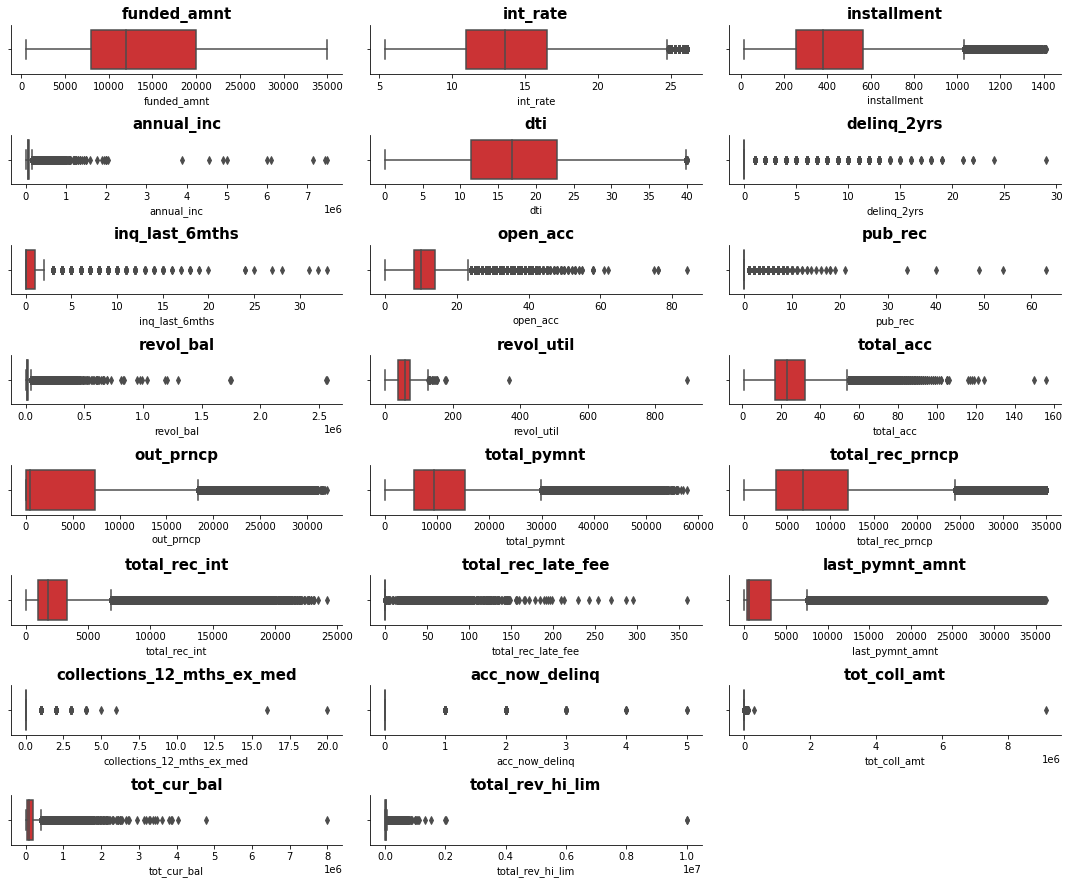

In [104]:
plt.figure(figsize=(15,15))
for i in range(len(num[:-1])):
    plt.subplot(10,3, i+1)
    ax = sns.boxplot(x=num[i], data=df, palette='Set1')
    ax.set_title(num[i], fontsize=15, color='black', weight='bold')

sns.despine()
plt.tight_layout()
plt.show()

In [105]:
def check_outliers(x,df):

    q1 = df[x].quantile(0.25)
    q3 = df[x].quantile(0.75)
    iqr = q3 - q1
    low_lim = q1 - (1.5 * iqr)
    hi_lim = q3 + (1.5 * iqr)
    filterred = ((df[x]<low_lim) | (df[x]>hi_lim))
    df_out = df[filterred]
    percent_out = (df_out.shape[0])/(df.shape[0])*100
    return x,round(percent_out,2)
    # print(f'Presentase outlier {x}:',round(percent_out,2),'%')

outlier = []
for i in num[:-1]:
    if check_outliers(i,df)[1] > 1:
        outlier.append(check_outliers(i,df)[0])
    print(check_outliers(i,df)[0],':',check_outliers(i,df)[1],'%')

funded_amnt : 0.0 %
int_rate : 1.05 %
installment : 2.51 %
annual_inc : 4.27 %
dti : 0.01 %
delinq_2yrs : 17.87 %
inq_last_6mths : 7.89 %
open_acc : 2.24 %
pub_rec : 13.16 %
revol_bal : 4.91 %
revol_util : 0.0 %
total_acc : 1.86 %
out_prncp : 5.0 %
total_pymnt : 4.08 %
total_rec_prncp : 4.43 %
total_rec_int : 6.68 %
total_rec_late_fee : 2.29 %
last_pymnt_amnt : 15.09 %
collections_12_mths_ex_med : 0.84 %
acc_now_delinq : 0.37 %
tot_coll_amt : 10.67 %
tot_cur_bal : 4.52 %
total_rev_hi_lim : 7.07 %


In [106]:
shape_before = df.shape
def zscore_handling(x):
    global df
    z_score = np.abs(stats.zscore(df[x]))
    filtered = (z_score < 3)
    df = df[filtered]

for i in outlier:
    zscore_handling(i)
    
shape_after = df.shape

print('size before :',shape_before)
print('size after :',shape_after)

size before : (466285, 31)
size after : (360536, 31)


## Data Transformation

In [107]:
df_trans = df.copy()

### Label Encoding

In [108]:
df_trans[cat].nunique()

term                    2
grade                   7
emp_length             12
home_ownership          6
verification_status     3
purpose                14
initial_list_status     2
dtype: int64

In [109]:
for i in cat:
    print(f"{i} : {df_trans[i].nunique()} : {df_trans[i].unique()}")

term : 2 : [' 36 months' ' 60 months']
grade : 7 : ['B' 'C' 'A' 'E' 'F' 'D' 'G']
emp_length : 12 : ['10+ years' '1 year' '3 years' '8 years' '9 years' '4 years' '< 1 year'
 '5 years' '6 years' '2 years' '7 years' 0]
home_ownership : 6 : ['RENT' 'OWN' 'MORTGAGE' 'OTHER' 'NONE' 'ANY']
verification_status : 3 : ['Verified' 'Not Verified' 'Source Verified']
purpose : 14 : ['credit_card' 'small_business' 'other' 'wedding' 'debt_consolidation'
 'car' 'home_improvement' 'major_purchase' 'moving' 'medical' 'house'
 'vacation' 'renewable_energy' 'educational']
initial_list_status : 2 : ['f' 'w']


In [110]:
#Encode columns with 2 unique values
le_term = LabelEncoder()
le_init = LabelEncoder()
df_trans['term'] = le_term.fit_transform(df_trans['term'])
df_trans['initial_list_status'] = le_init.fit_transform(df_trans['initial_list_status'])

In [111]:
#Encode grade with ordered
grade_class = df_trans['grade'].unique().tolist()
grade_class.sort()
le_grade = LabelEncoder()
le_grade.fit(grade_class)
df_trans['grade'] = le_grade.transform(df_trans['grade'])

In [112]:
#Encode emp_length with ordered length
emp_len_class = [0,'< 1 year','1 year','2 years','3 years','4 years','5 years','6 years','7 years',
                 '8 years','9 years','10+ years']
le_emp_len = LabelEncoder()
le_emp_len.fit(emp_len_class)
df_trans['emp_length'] = le_emp_len.transform(df_trans['emp_length'])

In [113]:
#One Hot Encode
ohe = pd.get_dummies(df_trans[cat],columns=['home_ownership','verification_status','purpose'],drop_first=True)

In [114]:
ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 360536 entries, 0 to 466284
Data columns (total 24 columns):
 #   Column                               Non-Null Count   Dtype
---  ------                               --------------   -----
 0   term                                 360536 non-null  int32
 1   grade                                360536 non-null  int32
 2   emp_length                           360536 non-null  int32
 3   initial_list_status                  360536 non-null  int32
 4   home_ownership_MORTGAGE              360536 non-null  uint8
 5   home_ownership_NONE                  360536 non-null  uint8
 6   home_ownership_OTHER                 360536 non-null  uint8
 7   home_ownership_OWN                   360536 non-null  uint8
 8   home_ownership_RENT                  360536 non-null  uint8
 9   verification_status_Source Verified  360536 non-null  uint8
 10  verification_status_Verified         360536 non-null  uint8
 11  purpose_credit_card                  36

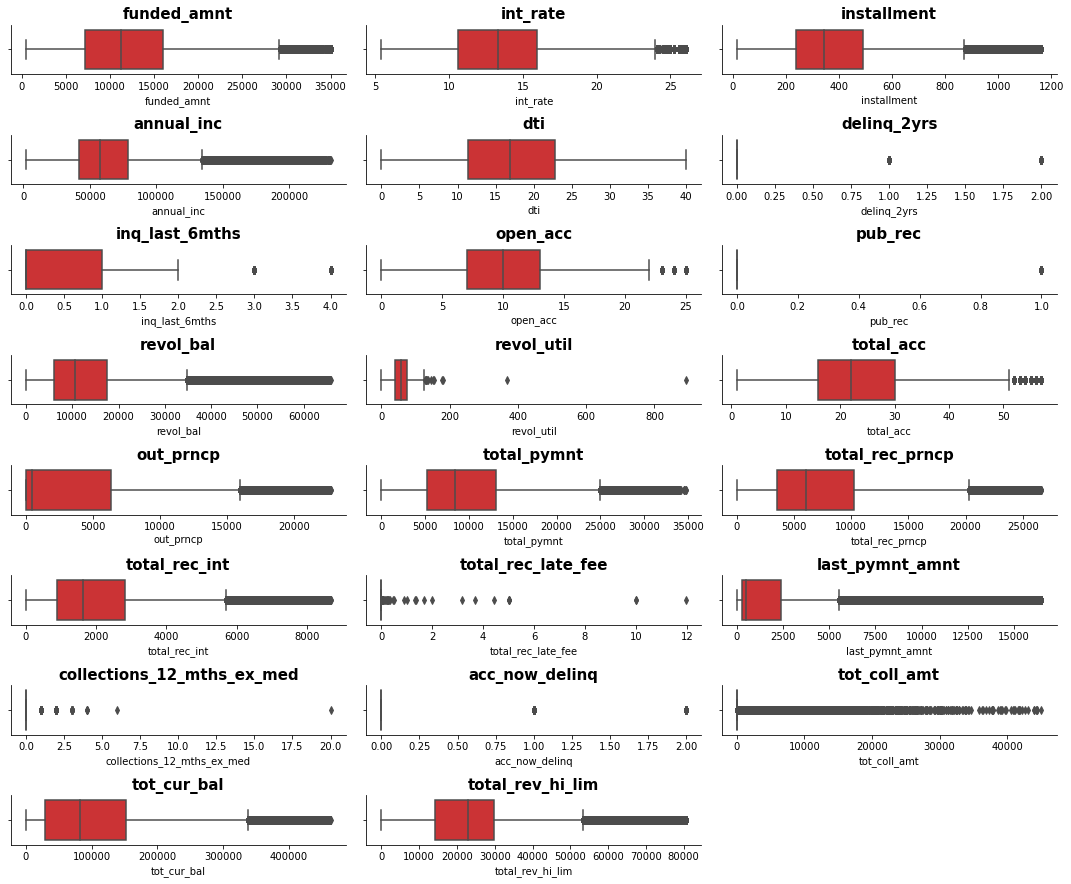

In [115]:
plt.figure(figsize=(15,15))
for i in range(len(num[:-1])):
    plt.subplot(10,3, i+1)
    ax = sns.boxplot(x=num[i], data=df_trans, palette='Set1')
    ax.set_title(num[i], fontsize=15, color='black', weight='bold')

sns.despine()
plt.tight_layout()
plt.show()

### Log trasnformation

In [116]:
log_col = ['funded_amnt','installment','annual_inc','revol_bal','out_prncp','total_pymnt','total_rec_prncp',
           'total_rec_int','last_pymnt_amnt','tot_coll_amt','tot_cur_bal','total_rev_hi_lim']
for i in log_col:
    df_trans[i] = np.log(1+df_trans[i])

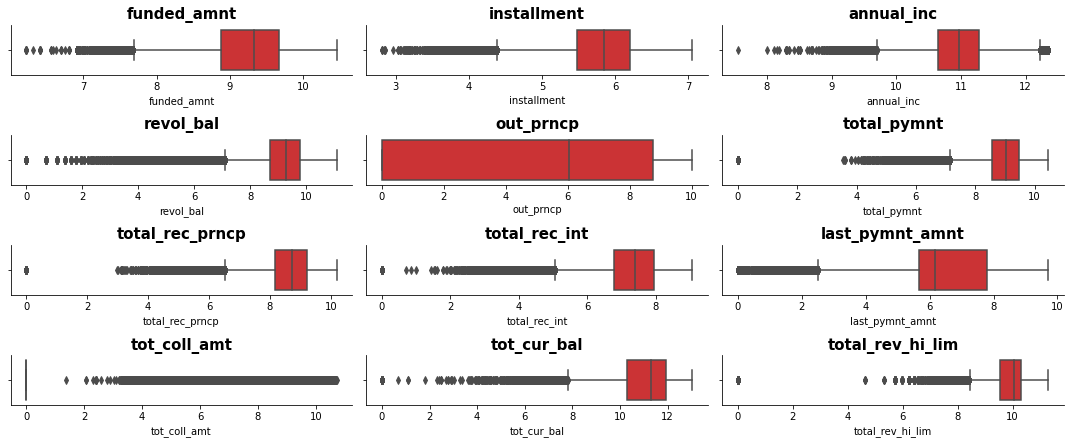

In [117]:
plt.figure(figsize=(15,15))
for i in range(len(log_col)):
    plt.subplot(10,3, i+1)
    ax = sns.boxplot(x=log_col[i], data=df_trans, palette='Set1')
    ax.set_title(log_col[i], fontsize=15, color='black', weight='bold')

sns.despine()
plt.tight_layout()
plt.show()

### Normalization


In [118]:
scaler = MinMaxScaler()
for i in num:
    df_trans[[i]] = scaler.fit_transform(df_trans[[i]])

# Train test data

In [119]:
X = pd.concat([df_trans[num],ohe],axis=1)
y = X.pop('status')

In [120]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 360536 entries, 0 to 466284
Data columns (total 47 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   funded_amnt                          360536 non-null  float64
 1   int_rate                             360536 non-null  float64
 2   installment                          360536 non-null  float64
 3   annual_inc                           360536 non-null  float64
 4   dti                                  360536 non-null  float64
 5   delinq_2yrs                          360536 non-null  float64
 6   inq_last_6mths                       360536 non-null  float64
 7   open_acc                             360536 non-null  float64
 8   pub_rec                              360536 non-null  float64
 9   revol_bal                            360536 non-null  float64
 10  revol_util                           360536 non-null  float64
 11  total_acc    

In [121]:
X.describe()

,funded_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
count,360536.000000,360536.000000,360536.000000,360536.000000,360536.000000,360536.000000,360536.000000,360536.000000,360536.000000,360536.000000,...,360536.000000,360536.000000,360536.000000,360536.000000,360536.000000,360536.000000,360536.000000,360536.000000,360536.000000,360536.000000
mean,0.714932,0.390086,0.700683,0.709478,0.430166,0.094047,0.182789,0.422293,0.127718,0.822415,...,0.052694,0.004435,0.022073,0.010396,0.007003,0.053493,0.000788,0.013416,0.005963,0.005508
std,0.146948,0.201117,0.137768,0.097488,0.196928,0.235022,0.238950,0.173882,0.333776,0.100748,...,0.223422,0.066449,0.146920,0.101428,0.083393,0.225014,0.028055,0.115049,0.076992,0.074014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.627659,0.252907,0.627274,0.644861,0.282821,0.000000,0.000000,0.280000,0.000000,0.784486,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.733786,0.384205,0.714415,0.712058,0.421105,0.000000,0.000000,0.400000,0.000000,0.836058,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.815679,0.512112,0.797697,0.776390,0.569892,0.000000,0.250000,0.520000,0.000000,0.880826,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,train_size=0.7)

## Unbalance data handling

In [123]:
y_train.value_counts()

1.0    223578
0.0     28797
Name: status, dtype: int64

In [124]:
X_SMOTE, y_SMOTE = over_sampling.SMOTE(random_state=457).fit_resample(X_train,y_train)

In [125]:
y_SMOTE.value_counts()

1.0    223578
0.0    223578
Name: status, dtype: int64

# Modelling

In [54]:
models = {'LogisticRegression': LogisticRegression(random_state=42),
         'RandomForestClassifier': RandomForestClassifier(random_state=42),
         'XGBClassifier':XGBClassifier(random_state=42),
         'DecisionTreeClassifier':DecisionTreeClassifier(random_state=42),
         'LGBMClassifier':LGBMClassifier(random_state=42)}

In [55]:
model_name = []
acc = []
f1 = []
pre = []
rec = []
score = {'acc':'accuracy',
        'prec':'precision',
        'rec':'recall',
        'f1':'f1'}
for i in models.keys():
    scores = cross_validate(models[i], X_SMOTE, y_SMOTE, cv=5, scoring=score)
    model_name.append(i)
    acc.append(scores['test_acc'].mean())
    pre.append(scores['test_prec'].mean())
    rec.append(scores['test_rec'].mean())
    f1.append(scores['test_f1'].mean())
        
df_eval = pd.DataFrame({'model_name':model_name,'accuracy_score':acc,'precision_score':pre,'recall_score':rec,'f1_score':f1})

## Model Evaluation

In [56]:
df_eval

,model_name,accuracy_score,precision_score,recall_score,f1_score
0,LogisticRegression,0.927441,0.898244,0.964352,0.930066
1,RandomForestClassifier,0.981036,0.965145,0.999025,0.981588
2,XGBClassifier,0.985656,0.974863,0.999298,0.986411
3,DecisionTreeClassifier,0.966479,0.967653,0.966571,0.966682
4,LGBMClassifier,0.984241,0.971613,0.999597,0.984963


## Hyperparameter Tuning

In [57]:
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300]
}

In [58]:
model = XGBClassifier(random_state=42)

In [59]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy')
grid_search.fit(X_SMOTE, y_SMOTE)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             param_grid={'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [60]:
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'max_depth': 7, 'n_estimators': 100}


best_params = {'max_depth': 7, 'n_estimators': 100}

In [62]:
print("Best Parameters:", best_params)

Best Parameters: {'max_depth': 7, 'n_estimators': 200}


## Hyperparameter Tuning Evaluation

In [126]:
best_model = XGBClassifier(random_state=42,**best_params)

In [127]:
scores = cross_validate(best_model, X_SMOTE, y_SMOTE, cv=5, scoring=score)
hyper_df = pd.DataFrame({'model_name':['best_XGB'],'accuracy_score':[scores['test_acc'].mean()],
                         'precision_score':[scores['test_prec'].mean()],
                         'recall_score':[scores['test_rec'].mean()],
                         'f1_score':[scores['test_f1'].mean()]})

KeyboardInterrupt: 

In [ ]:
pd.concat([df_eval[df_eval['model_name']=='XGBClassifier'],hyper_df],axis=0)

## Evaluation

In [195]:
best_model.fit(X_SMOTE, y_SMOTE)
predict = best_model.predict(X_test)

acu = accuracy_score(y_test,predict)
pre = precision_score(y_test,predict)
rec = recall_score(y_test,predict)
f1 = f1_score(y_test,predict)

print('Accuracy :',acu)
print('Precision :',pre)
print('Recall :',rec)
print('f1 :',f1)

KeyboardInterrupt: 

In [ ]:

cm = confusion_matrix(y_test, predict, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=best_model.classes_)

fig, ax = plt.subplots(figsize=(6,6))
# disp.figure_(figsize=(10,10))
disp.plot(colorbar=False,ax=ax,cmap='winter',text_kw={'fontsize':12, 'color':'black'})
plt.title('Confussion Matrix',fontsize=15, color='black', weight='bold')
# plt.figure(figsize=(9,9))
plt.savefig('loan_status_prediction/images/cm.jpg', dpi=400)

plt.show()

In [ ]:
importance = best_model.feature_importances_
plt.figure(figsize=(10,6))
feature_importdf = pd.DataFrame({'feature':X_SMOTE.columns,'import':importance})
df_fi = feature_importdf.sort_values(by='import',ascending=False).head(10)

fig,ax=plt.subplots(1,1,figsize=(10,6))
sns.barplot(data=df_fi,x='import',y='feature',color='b',ax=ax)
plt.bar_label(ax.containers[0], padding=2)
plt.title('Feature Importance',fontsize=15, color='black', weight='bold')
sns.despine()
plt.savefig('loan_status_prediction/images/fi.jpg', dpi=400)

plt.show()

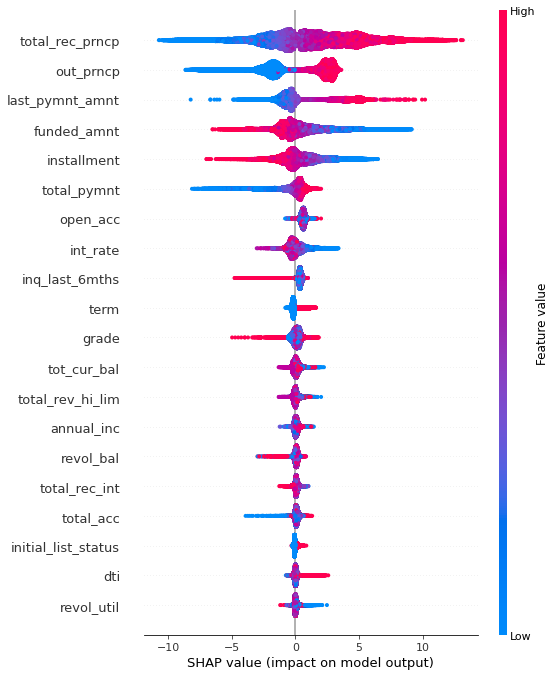

In [131]:
import shap

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

# Insight & Recommendation

## Insight

In [167]:
df_ = pd.concat([df_trans[num],ohe],axis=1)
df_ = df_[top_feature.tolist() + ['status']]

In [168]:
data_col = ['out_prncp', 'total_rec_prncp', 'last_pymnt_amnt', 'funded_amnt',
       'inq_last_6mths', 'delinq_2yrs', 'open_acc', 
       'pub_rec', 'tot_coll_amt']
for i in data_col:
    df_[i] = df[i]

In [175]:
top_feature

array(['out_prncp', 'total_rec_prncp', 'last_pymnt_amnt', 'funded_amnt',
       'inq_last_6mths', 'delinq_2yrs', 'open_acc', 'home_ownership_NONE',
       'pub_rec', 'tot_coll_amt'], dtype=object)

In [169]:
df_.head()

,out_prncp,total_rec_prncp,last_pymnt_amnt,funded_amnt,inq_last_6mths,delinq_2yrs,open_acc,home_ownership_NONE,pub_rec,tot_coll_amt,status
0,0.00,5000.00,171.62,5000,1.0,0.0,3.0,0,0.0,0.0,1.0
2,0.00,2400.00,649.91,2400,2.0,0.0,2.0,0,0.0,0.0,1.0
4,766.90,2233.10,67.79,3000,0.0,0.0,15.0,0,0.0,0.0,1.0
5,0.00,5000.00,161.03,5000,3.0,0.0,9.0,0,0.0,0.0,1.0
6,1889.15,5110.85,170.08,7000,1.0,0.0,7.0,0,0.0,0.0,1.0


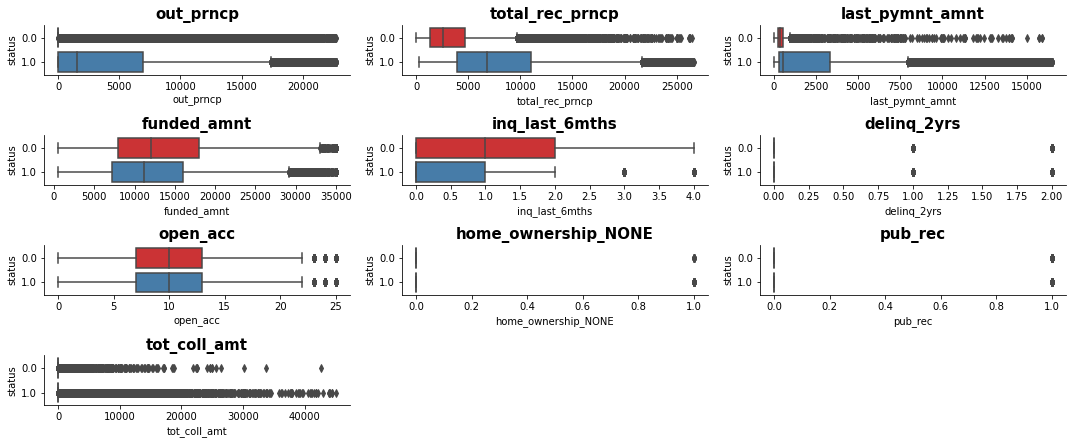

In [171]:
df_['status'] = df_['status'].astype('category')
plt.figure(figsize=(15,15))
for i in range(len(df_.columns[:-1])):
    plt.subplot(10,3, i+1)
    ax = sns.boxplot(x=df_.columns[:-1][i], data=df_, palette='Set1',y='status')
    ax.set_title(df_.columns[:-1][i], fontsize=15, color='black', weight='bold')

sns.despine()
plt.tight_layout()
plt.savefig('insight_num.jpg', dpi=400)

plt.show()

In [170]:
top_feature = df_fi['feature'].values
df_.groupby('status')[df_.columns[:-1]].mean()

,out_prncp,total_rec_prncp,last_pymnt_amnt,funded_amnt,inq_last_6mths,delinq_2yrs,open_acc,home_ownership_NONE,pub_rec,tot_coll_amt
status,,,,,,,,,,
0.0,1229.949857,3508.081394,434.561216,13358.279868,0.956401,0.183435,10.605765,0.000267,0.117551,94.258652
1.0,4084.350672,8092.497788,2497.430977,12180.714601,0.702137,0.188695,10.551079,0.000088,0.129028,136.855868


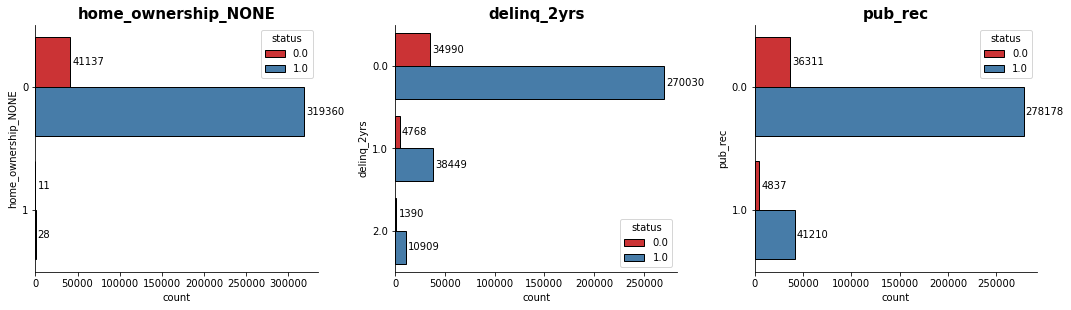

In [186]:
plt.figure(figsize=(15,20))
cat_feat = ['home_ownership_NONE','delinq_2yrs','pub_rec']
for i in range(len(cat_feat)):
    plt.subplot(5,3, i+1)
    ax = sns.countplot(y=cat_feat[i], data=df_, palette='Set1', order=df_[cat_feat[i]].value_counts().index,edgecolor='black',hue='status')
    plt.bar_label(ax.containers[0], padding=2)
    plt.bar_label(ax.containers[1], padding=2)
    ax.set_title(cat_feat[i], fontsize=15, color='black', weight='bold')
sns.despine()
plt.tight_layout()
plt.savefig('insight_cat.jpg', dpi=400)

plt.show()

- out_prncp : Remaining outstanding principal for total amount funded
- total_rec_prncp : Principal received to date
- last_pymnt_amnt : Last total payment amount received
- funded_amnt : The total amount committed to that loan at that point in time.
- inq_last_6mths : The number of inquiries in past 6 months (excluding auto and mortgage inquiries)
- delinq_2yrs : The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
- open_acc : The number of open credit lines in the borrower's credit file.
- home_ownership : The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER.
- pub_rec : Number of derogatory public records
- tot_coll_amt : Total collection amounts ever owed


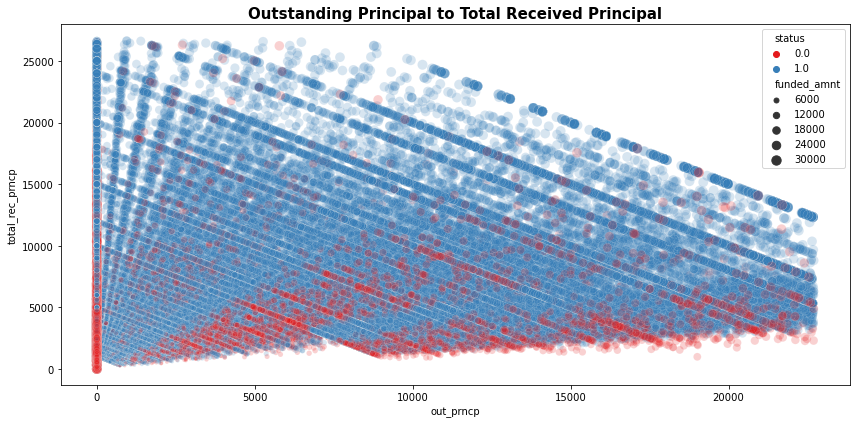

In [184]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=df_,x='out_prncp',y='total_rec_prncp',hue='status',palette="Set1",alpha=0.2,size='funded_amnt',sizes=(10, 100))
plt.title('Outstanding Principal to Total Received Principal', fontsize=15, color='black', weight='bold')
plt.tight_layout()
plt.savefig('insight1.jpg', dpi=400)

plt.show()

**Outstanding Principal & Total Received Principal** <br>
The highest importance is outstanding principal then total received principal, in this feature there is significant difference between positive and negative borrowers. negative borrowers tend to have lower outstanding principal and total received principal. From scatterplot above we can see there is area where negative borrowershave focused distribution in low total received principal and high outstanding principal. From this data there is 4 types of negative borrowers based on outstanding principal and total received principal, we can sorted from high chance negative borrowers based on visual representative (number range are visually stated) :
1. Low outstanding, low total received (total received < 5000, outstanding = 0)
2. High outstanding, low total received (total received < 5000, outstanding 7000 - 22000)
3. Medium outstanding, medium total received (total received < 15000, outstanding 1000 - 15000)
4. Low outstanding, high total received (total received 5000 - 20000, outstanding 1000 - 6000)

There are no significant different in funded amount central tendencies between positive loan and negative loan, but from histogram we can see for some amount there are low distribution of negative loan such as funded amount at 500, 10000, 15000, 20000. With this data we can suggest to provide fix amount of loan to reduce the negative loaners.

Positive loaners have focused distribution of remaining outstanding principal it is aroung 0 to 8000, negative loan have random distribution. With this data we can know that positive loaners have often had loan remaining around the certain range, but this data not strong enough to prove whether it is negative or positive.

From total recieved principal positive loaners have higher distribution than negative loaners. From this data we can possibly interpret that negative loaners less like to pay the installment, assume the total time are equal.

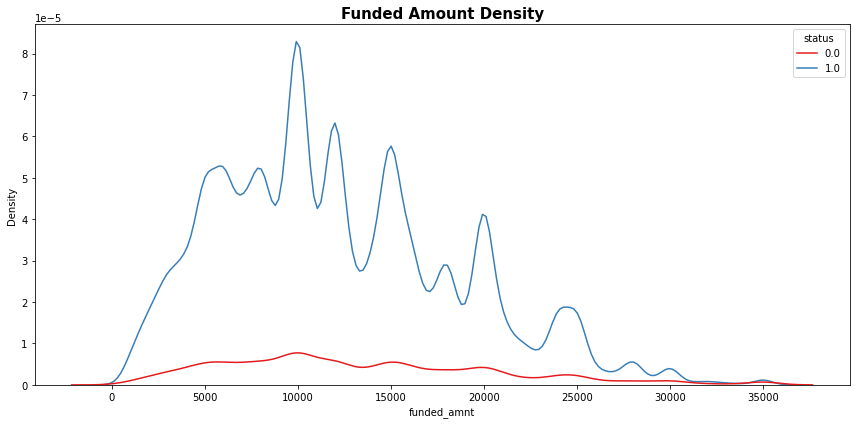

In [188]:
plt.figure(figsize=(12,6))

sns.kdeplot(data=df_, x='funded_amnt',hue='status',palette='Set1')
plt.title('Funded Amount Density', fontsize=15, color='black', weight='bold')
plt.tight_layout()
plt.savefig('insight2.jpg', dpi=400)

plt.show()

**Funded Amount** <br>
Borrowers status have slightly difference on funded amount average, but from density plot we can see some patter where positive borrowers focused. Positive borrowers are mostly have high density on some certain amount such as 5000, 1000, 15000, 20000. This patter can became useful insight where company have less possibility to get negative borrowers if applied loan on for certain of amount.

## Recommendation

From some insight above we can recommend company to :
   1. Assest outstanding principal and total received principal, with this 2 feature we can consider borrowers possibility to become negative borrowers. Need to research further to build segmentation alogarithm to know borrowers possibility degree.
   2. Apply fixed funded amount, create fixed loan product to avoid negative borrowers. Based on density plot of funded amount some funded amount have high density of positive borrowers, this means possibility to get negative borrowers are low.